In [3]:
# Imports
import torch
import math, time
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

In [4]:
# Load data
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

In [5]:
dataset = train
X = dataset[test.columns]
y = dataset['SalePrice']
X.shape,y.shape

((1460, 80), (1460,))

In [6]:
numerical_columns = X.select_dtypes(include=['int', 'float']).columns
X_num = X.loc[:, numerical_columns]

# Select the categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
X_cat = X.loc[:, categorical_columns]

In [7]:
X_num.columns, X_cat.columns

(Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
        'MiscVal', 'MoSold', 'YrSold'],
       dtype='object'),
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating'

- What numerical features can we create with this base

### LotFrontage & LotArea

In [8]:
# We have LotFrontage and LotArea
print(X_num[['LotFrontage', 'LotArea']][:10])
print('\nCorrelation','LotFrontage', 'LotArea:', X_num[['LotFrontage', 'LotArea']].corr()['LotFrontage'][1])

   LotFrontage  LotArea
0         65.0     8450
1         80.0     9600
2         68.0    11250
3         60.0     9550
4         84.0    14260
5         85.0    14115
6         75.0    10084
7          NaN    10382
8         51.0     6120
9         50.0     7420

Correlation LotFrontage LotArea: 0.4260950187718081


In [9]:
# Check null values
X_num['LotFrontage'].isnull().sum(), X_num['LotArea'].isnull().sum()

(259, 0)

In [10]:
X['Street'].unique()

array(['Pave', 'Grvl'], dtype=object)

In [11]:
X[X_num['LotFrontage'].isnull()]['Street'].isnull().sum()
# There are 0 datapoints with missing LotFrontage data that has null Street

0

In [12]:
X[X['LotFrontage'] > 0]['LotFrontage'].sort_values()
# There are no 0 LotFrontage
# So, assuming we have Street data for all the datapoints with missing LotFrontage data
# We should try completing the missing LotFrontage data with something more than 0

232      21.0
837      21.0
235      21.0
1029     21.0
1038     21.0
        ...  
231     174.0
197     174.0
1127    182.0
934     313.0
1298    313.0
Name: LotFrontage, Length: 1201, dtype: float64

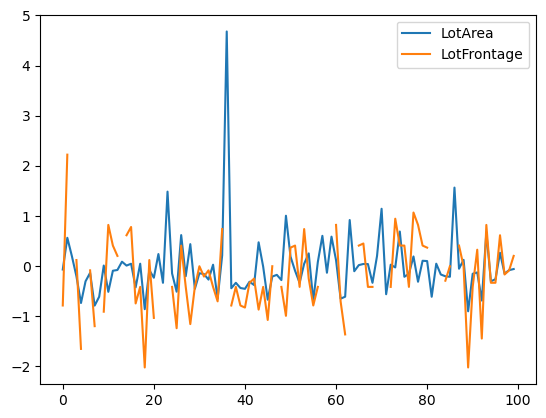

In [13]:
# Assuming the relation of LotArea and LotFrontage, we can estimate the value for
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X[['LotArea', 'LotFrontage']])
pd.DataFrame(scaled_data[-100:], columns=['LotArea', 'LotFrontage']).plot();

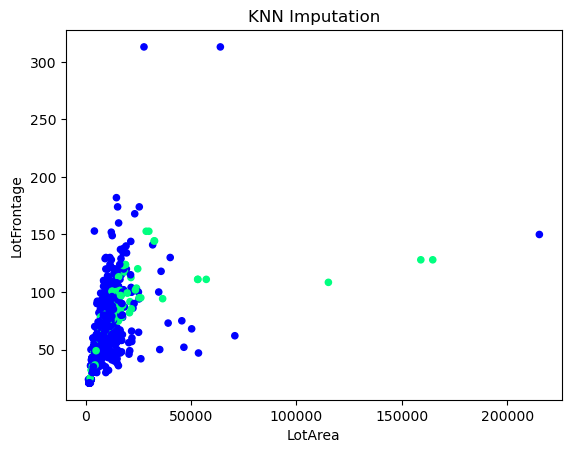

In [14]:
df_knn = X.filter(['LotFrontage','LotArea'], axis=1).copy()

df_knn = pd.DataFrame(df_knn, columns = df_knn.columns)

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

fig = plt.Figure()
null_values = X["LotFrontage"].isnull() 
fig = df_knn_imputed.plot(x="LotArea", y="LotFrontage", kind="scatter", c=null_values, cmap='winter', title='KNN Imputation', colorbar=False)

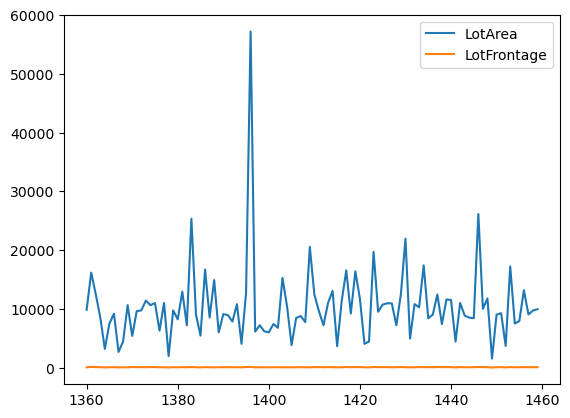

In [15]:
df_knn_imputed = pd.DataFrame(df_knn_imputed, columns=['LotArea', 'LotFrontage'])
df_knn_imputed[-100:].plot();

In [16]:
X['LotFrontage'] = df_knn_imputed['LotFrontage']

/tmp/ipykernel_324618/1003399457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['LotFrontage'] = df_knn_imputed['LotFrontage']


In [17]:
X['LotFrontage'].isnull().sum()

0

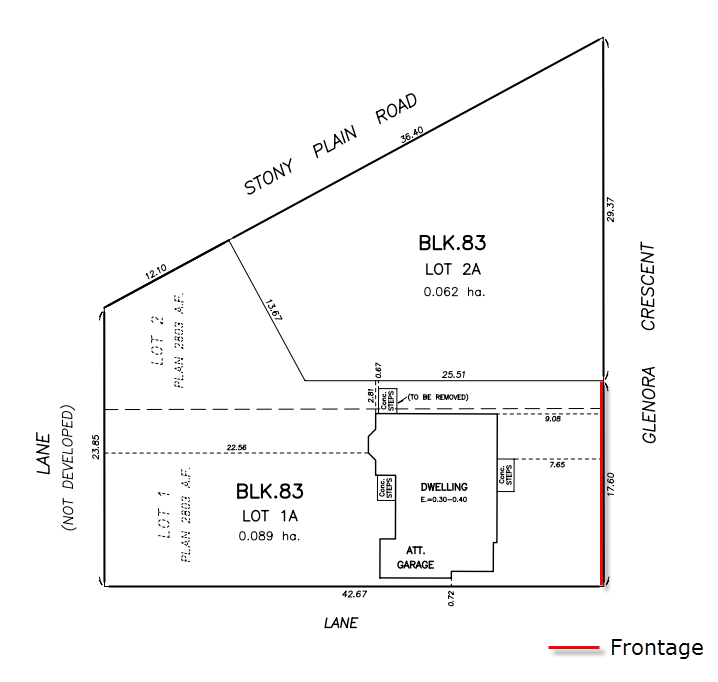

-  I want to create a new feature combining LotFrontage and LotArea. They are in completely different formats, one is a huge number for the Area in squared meters, and the other a small number in meters.
- The sum wouldn't add much value because it would be highly correlated to the Area, meaning it's not worth much than the Area feature.
- But if I calculate the root of the area and sum it to the lot frontage, it would make more sense.

In [18]:
X_num['LotTotal'] = X_num['LotFrontage'] + X_num['LotArea']**(1/2)

In [19]:
pd.concat([X_num[['LotTotal', 'LotFrontage', 'LotArea']], y], axis=1).corr()

,LotTotal,LotFrontage,LotArea,SalePrice
LotTotal,1.000000,0.891255,0.740322,0.428871
LotFrontage,0.891255,1.000000,0.426095,0.351799
LotArea,0.740322,0.426095,1.000000,0.263843
SalePrice,0.428871,0.351799,0.263843,1.000000


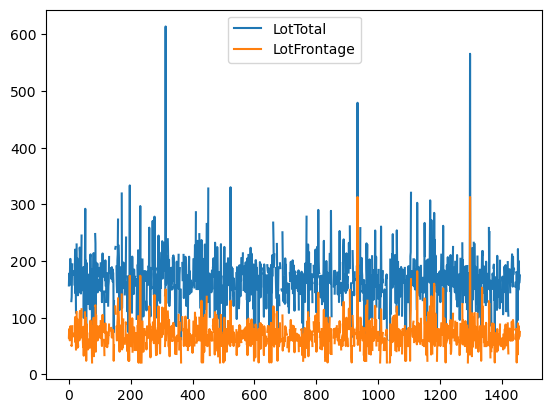

In [20]:
X_num[['LotTotal', 'LotFrontage']].plot();

- The new feature improves the correlation as it now is able to combine the relation between both.

### Quality and Condition Overall

- The Overall Quality and Condition are 1-10 ratings
- OverallCond is not a very good price predictor but it could help when combined with OverallQual

In [21]:
X_num['QualCondSum'] = X_num['OverallQual'] + X_num['OverallCond']
pd.concat([X_num[['OverallQual', 'OverallCond', 'QualCondSum']], y], axis=1).corr()

,OverallQual,OverallCond,QualCondSum,SalePrice
OverallQual,1.000000,-0.091932,0.756229,0.790982
OverallCond,-0.091932,1.000000,0.582014,-0.077856
QualCondSum,0.756229,0.582014,1.000000,0.594786
SalePrice,0.790982,-0.077856,0.594786,1.000000


In [22]:
X_num[['OverallQual', 'OverallCond', 'QualCondSum']].mean()

OverallQual     6.099315
OverallCond     5.575342
QualCondSum    11.674658
dtype: float64

 - Correlation of 0.594786 with the new feature is worse than OverallQual, but better than OverallCond, so I should't use this in the features subset.

### Floor Square Feet
- The sum of the floor sqft could be a potential good price predictor

In [23]:
X_num['1st2ndFlrSF_Sum'] = X_num['1stFlrSF'] + X_num['2ndFlrSF']
pd.concat([X_num[['1st2ndFlrSF_Sum', '2ndFlrSF', '1stFlrSF']], y], axis=1).corr()

,1st2ndFlrSF_Sum,2ndFlrSF,1stFlrSF,SalePrice
1st2ndFlrSF_Sum,1.000000,0.687285,0.572041,0.716883
2ndFlrSF,0.687285,1.000000,-0.202646,0.319334
1stFlrSF,0.572041,-0.202646,1.000000,0.605852
SalePrice,0.716883,0.319334,0.605852,1.000000


- The sum of the first and second floor square feet did improve the correlation from 0.605852 to 0.732636, so this one is being included.

### Year Build and Year Remodelation
- If no remodelation, then the year stays the same, so my guess is that if there is no remodelation, or 0, the price should be lower, and vice versa.

In [24]:
X_num['YearDiffRemod'] = X_num['YearRemodAdd'] - X_num['YearBuilt']
pd.concat([X_num[['YearDiffRemod', 'YearRemodAdd', 'YearBuilt']], y], axis=1).corr()

,YearDiffRemod,YearRemodAdd,YearBuilt,SalePrice
YearDiffRemod,1.000000,0.111922,-0.733896,-0.217503
YearRemodAdd,0.111922,1.000000,0.592855,0.507101
YearBuilt,-0.733896,0.592855,1.000000,0.522897
SalePrice,-0.217503,0.507101,0.522897,1.000000


<AxesSubplot: >

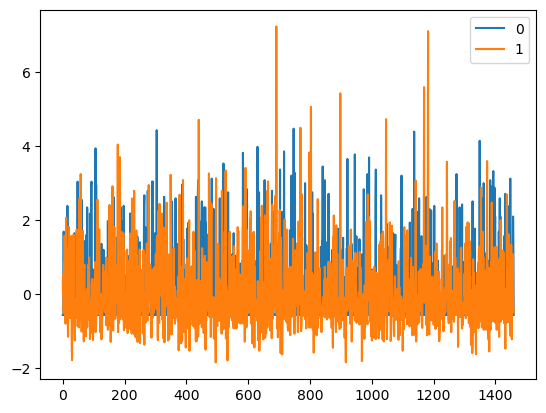

In [25]:
pd.DataFrame(scaler.fit_transform(pd.concat([X_num[['YearDiffRemod']], y], axis=1))).plot()

- The correlation is bad -0.017505 so I'm leaving this feature out.

### Garage Cars and Garage Area
- Bigger ratio of space for each car might be related to expensive houses

In [26]:
X_num['GarageCarsRatio'] = X_num['GarageArea'] / X_num['GarageCars']
pd.concat([X_num[['GarageCarsRatio', 'GarageCars', 'GarageArea']], y], axis=1).corr()

,GarageCarsRatio,GarageCars,GarageArea,SalePrice
GarageCarsRatio,1.000000,-0.203312,0.333006,-0.013972
GarageCars,-0.203312,1.000000,0.882475,0.640409
GarageArea,0.333006,0.882475,1.000000,0.623431
SalePrice,-0.013972,0.640409,0.623431,1.000000


In [27]:
X_num[['GarageCars', 'GarageArea', 'GarageCarsRatio']]

,GarageCars,GarageArea,GarageCarsRatio
0,2,548,274.000000
1,2,460,230.000000
2,2,608,304.000000
3,3,642,214.000000
4,3,836,278.666667
...,...,...,...
1455,2,460,230.000000
1456,2,500,250.000000
1457,1,252,252.000000
1458,1,240,240.000000


- It didn't perform as well also.

### All Areas

In [28]:
areas_columns = []
for name in X_num.columns:
    if 'Area' in name:
        areas_columns.append(name)
areas_columns
# I'm leaving pool area out because it barely has values.

['LotArea', 'MasVnrArea', 'GrLivArea', 'GarageArea', 'PoolArea']

In [29]:
X_num['AllAreasSum'] = X_num['LotArea'] + X_num['MasVnrArea'] + X_num['GrLivArea'] + X_num['GarageArea']
pd.concat([X_num[['AllAreasSum', 'LotArea', 'MasVnrArea', 'GrLivArea', 'GarageArea', ]], y], axis=1).corr()

,AllAreasSum,LotArea,MasVnrArea,GrLivArea,GarageArea,SalePrice
AllAreasSum,1.000000,0.997474,0.147588,0.323772,0.228624,0.317032
LotArea,0.997474,1.000000,0.104160,0.263116,0.180403,0.263843
MasVnrArea,0.147588,0.104160,1.000000,0.390857,0.373066,0.477493
GrLivArea,0.323772,0.263116,0.390857,1.000000,0.468997,0.708624
GarageArea,0.228624,0.180403,0.373066,0.468997,1.000000,0.623431
SalePrice,0.317032,0.263843,0.477493,0.708624,0.623431,1.000000
